In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
data=pd.read_csv("finalpreprocessed_detailed.csv")
print(data.shape)
gan=pd.read_csv("synthetic_dataGAN.csv").drop(['Unnamed: 0', 'id'], axis=1)
print(gan.shape)
gc=pd.read_csv("synthetic_dataGC.csv").drop(['Unnamed: 0', 'id'], axis=1)
print(gc.shape)
# data=pd.read_csv("finalpreprocessed_simple.csv")
# print(data.shape)
data=pd.read_csv("data25_detailed.csv")
print(data.shape)

(61050, 144)
(10000, 144)
(10000, 144)
(61050, 26)


In [ ]:
gan_3x = pd.concat([gan]*3, ignore_index=True)
gc_2x = pd.concat([gc]*2, ignore_index=True)
data = pd.concat([data, gan_3x, gc_2x], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data['CVD'].value_counts()

0.0    54843
1.0     6207
Name: CVD, dtype: int64

In [ ]:
selected_features = 'AGEP_A,SEX_A,RACEALLP_A_1,RACEALLP_A_2,RACEALLP_A_3,RACEALLP_A_4,RACEALLP_A_5,RACEALLP_A_6,HYPEV_A,CHLEV_A,DIBTYPE_A_1,DIBTYPE_A_2,DIBTYPE_A_3,SMKCIGST_A_1,SMKCIGST_A_2,SMKCIGST_A_3,SMKCIGST_A_4,HYPMED_A,CVD'
selected_columns = selected_features.split(',')
selected_columns_with_occ = selected_columns.copy()+[col for col in data.columns if col.startswith("EMDOCCUPN") or col.startswith("EMDINDSTN") or col.startswith("EMDWRKCAT")]
pce_features_data = data[selected_columns]
pce_and_occ_features_data = data[selected_columns_with_occ]

# pce_features_data0=pce_features_data[pce_features_data['CVD']==0.0]
# pce_features_data1=pce_features_data[pce_features_data['CVD']==1.0]
# pce_features_data0=pce_features_data0.sample(n=10000, random_state=1)
# pce_features_data=pd.concat([pce_features_data0,pce_features_data1])
# pce_features_data= pce_features_data.sample(frac = 1)

# pce_and_occ_features_data0=pce_and_occ_features_data[pce_and_occ_features_data['CVD']==0.0]
# pce_and_occ_features_data1=pce_and_occ_features_data[pce_and_occ_features_data['CVD']==1.0]
# pce_and_occ_features_data0=pce_and_occ_features_data0.sample(n=10000, random_state=1)
# pce_and_occ_features_data=pd.concat([pce_and_occ_features_data0,pce_and_occ_features_data1])
# pce_and_occ_features_data= pce_and_occ_features_data.sample(frac = 1)

In [ ]:
X = pce_and_occ_features_data.drop('CVD', axis=1)
y = pce_and_occ_features_data['CVD']

In [ ]:
X = data.drop('CVD', axis=1)
y = data['CVD']

In [ ]:
# min_max_scaler = MinMaxScaler()
# X_normalized = min_max_scaler.fit_transform(X)
# standard_scaler = StandardScaler()
# X_standardized = standard_scaler.fit_transform(X_normalized)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# (we actually should not include any augmented data in test set)

#Model fitting
##Models fitted: Random Forest, LR with weights adjusted, SVM, GB

##Using PCE + Occupation Features

###Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm=confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy}')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
f1 = f1_score(y_test, y_pred)
(tn, fp, fn, tp, f1)

###Logistic Regression

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Find the class weights based on the inverse of their frequencies
class_weights = y.value_counts().to_dict()
weights = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]

for i in range(10):
  # Initialize the KFold cross-validator with 10 folds
  kf = KFold(n_splits=10)

  total_training_accuracy = 0
  total_testing_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0
  fold = 1

  class_weights[1.0] = weights[i]
  class_weights[0.0] = 1
  # for key in class_weights:
  #     class_weights[key] = 1 / class_weights[key]
  #     print(f"weight: class {key}: {class_weights[key]}")

  # Initialize the Logistic Regression model with class weights and max_iter=1000
  lr = LogisticRegression(max_iter=1000, class_weight=class_weights)

  for train_index, test_index in kf.split(X_standardized):
      X_train, X_test = X_standardized[train_index], X_standardized[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Train the model on the training data
      lr.fit(X_train, y_train)

      # Compute the training accuracy
      training_accuracy = lr.score(X_train, y_train)

      # Make predictions using the test data
      y_test_pred = lr.predict(X_test)

      # Compute the testing accuracy, precision, recall, and F1 score
      testing_accuracy = lr.score(X_test, y_test)
      precision = precision_score(y_test, y_test_pred)
      recall = recall_score(y_test, y_test_pred)
      f1 = f1_score(y_test, y_test_pred)

      # print(f"Fold {fold}:")
      # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
      # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
      # print(f"  Precision: {precision:.2f}")
      # print(f"  Recall: {recall:.2f}")
      # print(f"  F1 score: {f1:.2f}")
      # print()

      total_training_accuracy += training_accuracy
      total_testing_accuracy += testing_accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      fold += 1

  # Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
  average_training_accuracy = total_training_accuracy / (fold - 1)
  average_testing_accuracy = total_testing_accuracy / (fold - 1)
  average_precision = total_precision / (fold - 1)
  average_recall = total_recall / (fold - 1)
  average_f1 = total_f1 / (fold - 1)

  print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
  print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
  print(f"Average precision: {average_precision:.2f}")
  print(f"Average recall: {average_recall:.2f}")
  print(f"Average F1 score: {average_f1:.2f}")
  print()


###SVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Find the class weights based on the inverse of their frequencies
class_weights = y.value_counts().to_dict()
weights = [5, 6, 7, 8, 9]

for i in range(5):
  # Initialize the KFold cross-validator with 10 folds
  kf = KFold(n_splits=2, shuffle=True)

  total_training_accuracy = 0
  total_testing_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0
  fold = 1

  class_weights[1.0] = weights[i]
  class_weights[0.0] = 1

  clf = svm.SVC(class_weight=class_weights)

  for train_index, test_index in kf.split(X_standardized):
      X_train, X_test = X_standardized[train_index], X_standardized[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Train the model on the training data
      clf.fit(X_train, y_train)

      # Compute the training accuracy
      training_accuracy = clf.score(X_train, y_train)

      # Make predictions using the test data
      y_test_pred = clf.predict(X_test)

      # Compute the testing accuracy, precision, recall, and F1 score
      testing_accuracy = clf.score(X_test, y_test)
      precision = precision_score(y_test, y_test_pred)
      recall = recall_score(y_test, y_test_pred)
      f1 = f1_score(y_test, y_test_pred)

      # print(f"Fold {fold}:")
      # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
      # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
      # print(f"  Precision: {precision:.2f}")
      # print(f"  Recall: {recall:.2f}")
      # print(f"  F1 score: {f1:.2f}")
      # print()

      total_training_accuracy += training_accuracy
      total_testing_accuracy += testing_accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      fold += 1

  # Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
  average_training_accuracy = total_training_accuracy / (fold - 1)
  average_testing_accuracy = total_testing_accuracy / (fold - 1)
  average_precision = total_precision / (fold - 1)
  average_recall = total_recall / (fold - 1)
  average_f1 = total_f1 / (fold - 1)

  print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
  print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
  print(f"Average precision: {average_precision:.2f}")
  print(f"Average recall: {average_recall:.2f}")
  print(f"Average F1 score: {average_f1:.2f}")
  print()


###Neural Networks

#### keras tuner

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras import regularizers

def build_model(hp):
    model = keras.Sequential()
    # Use hp.Int to define the number of layers
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=128,
                                            step=32),
                               activation='relu',
                               kernel_regularizer=regularizers.l2(hp.Choice('l2_reg_'+str(i), values=[0.01, 0.001, 0.0001]))))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # use validation accuracy as the objective
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()

# Define class weights
class_weight = {0: 1., 1: 9.}

tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.3,
             class_weight=class_weight)  # add class weights here

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hp)
model.fit(X_train, y_train, class_weight=class_weight, epochs=10, validation_split=0.3)  # and here

model.predict(X_train[:1])
model.summary()


<ipython-input-8-5dea928aa34f>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
l2_reg_0 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
l2_reg_1 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
l2_reg_2 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_v

Epoch 1/15
935/935 [==============================] - 3s 3ms/step - loss: 0.8826 - accuracy: 0.7397 - val_loss: 0.5123 - val_accuracy: 0.7457
Epoch 2/15
935/935 [==============================] - 3s 3ms/step - loss: 0.8829 - accuracy: 0.7405 - val_loss: 0.4992 - val_accuracy: 0.7444
Epoch 3/15
935/935 [==============================] - 4s 4ms/step - loss: 0.8827 - accuracy: 0.7377 - val_loss: 0.4660 - val_accuracy: 0.7769
Epoch 4/15
935/935 [==============================] - 3s 3ms/step - loss: 0.8826 - accuracy: 0.7409 - val_loss: 0.5861 - val_accuracy: 0.6953
Epoch 5/15
935/935 [==============================] - 3s 3ms/step - loss: 0.8807 - accuracy: 0.7390 - val_loss: 0.5275 - val_accuracy: 0.7294
Epoch 6/15
935/935 [==============================] - 3s 3ms/step - loss: 0.8799 - accuracy: 0.7403 - val_loss: 0.6233 - val_accuracy: 0.6701
Epoch 7/15
935/935 [==============================] - 3s 4ms/step - loss: 0.8799 - accuracy: 0.7377 - val_loss: 0.4939 - val_accuracy: 0.7451
Epoch 

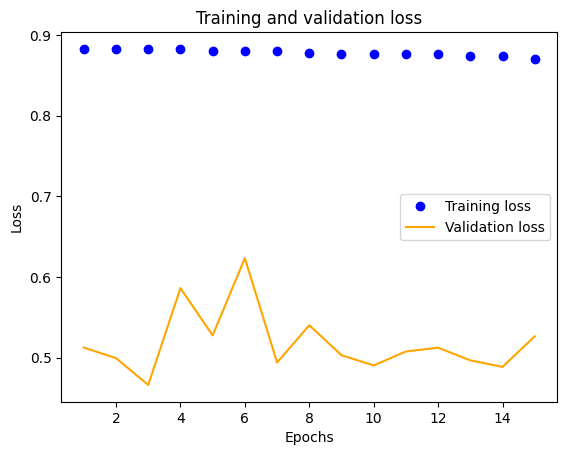

In [ ]:
history = model.fit(X_train, y_train, epochs=15, validation_split=0.3, class_weight=class_weight)

# Now you can create your plots
history_dict = history.history

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

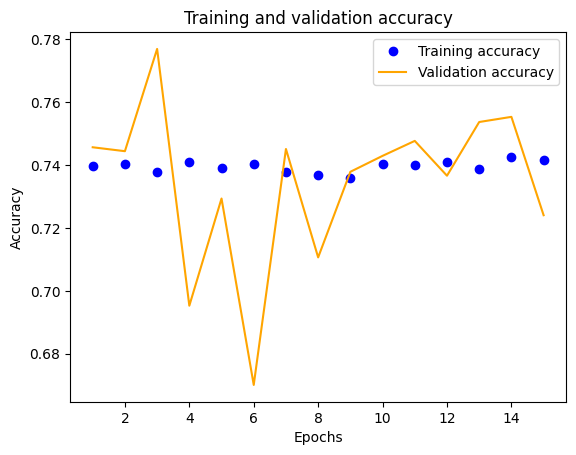

0.7769284844398499

In [ ]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)

print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

573/573 [==============================] - 1s 1ms/step
[[11708  4797]
 [  321  1489]]
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     16505
         1.0       0.24      0.82      0.37      1810

    accuracy                           0.72     18315
   macro avg       0.61      0.77      0.59     18315
weighted avg       0.90      0.72      0.78     18315



(11708, 4797, 321, 1489)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

preds = np.round(model.predict(X_test),0)

# Confusion matrix
print(confusion_matrix(y_test, preds)) # Order matters! (actual, predicted)

# Classification report
print(classification_report(y_test, preds))

# AUC-ROC
roc_auc = roc_auc_score(y_test, preds)
print("AUC-ROC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)


##Using PCE

In [ ]:
X = pce_features_data.drop('CVD', axis=1)
y = pce_features_data['CVD']

In [ ]:
# min_max_scaler = MinMaxScaler()
# X_normalized = min_max_scaler.fit_transform(X)
# standard_scaler = StandardScaler()
# X_standardized = standard_scaler.fit_transform(X_normalized)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm=confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy}')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
f1 = f1_score(y_test, y_pred)
(tn, fp, fn, tp, f1)

###Logistic Regression

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Find the class weights based on the inverse of their frequencies
class_weights = y.value_counts().to_dict()
weights = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]

for i in range(10):
  # Initialize the KFold cross-validator with 10 folds
  kf = KFold(n_splits=10)

  total_training_accuracy = 0
  total_testing_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0
  fold = 1

  class_weights[1.0] = weights[i]
  class_weights[0.0] = 1
  # for key in class_weights:
  #     class_weights[key] = 1 / class_weights[key]
  #     print(f"weight: class {key}: {class_weights[key]}")

  # Initialize the Logistic Regression model with class weights and max_iter=1000
  lr = LogisticRegression(max_iter=1000, class_weight=class_weights)

  for train_index, test_index in kf.split(X_standardized):
      X_train, X_test = X_standardized[train_index], X_standardized[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Train the model on the training data
      lr.fit(X_train, y_train)

      # Compute the training accuracy
      training_accuracy = lr.score(X_train, y_train)

      # Make predictions using the test data
      y_test_pred = lr.predict(X_test)

      # Compute the testing accuracy, precision, recall, and F1 score
      testing_accuracy = lr.score(X_test, y_test)
      precision = precision_score(y_test, y_test_pred)
      recall = recall_score(y_test, y_test_pred)
      f1 = f1_score(y_test, y_test_pred)

      # print(f"Fold {fold}:")
      # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
      # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
      # print(f"  Precision: {precision:.2f}")
      # print(f"  Recall: {recall:.2f}")
      # print(f"  F1 score: {f1:.2f}")
      # print()

      total_training_accuracy += training_accuracy
      total_testing_accuracy += testing_accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      fold += 1

  # Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
  average_training_accuracy = total_training_accuracy / (fold - 1)
  average_testing_accuracy = total_testing_accuracy / (fold - 1)
  average_precision = total_precision / (fold - 1)
  average_recall = total_recall / (fold - 1)
  average_f1 = total_f1 / (fold - 1)

  print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
  print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
  print(f"Average precision: {average_precision:.2f}")
  print(f"Average recall: {average_recall:.2f}")
  print(f"Average F1 score: {average_f1:.2f}")
  print()


###SVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Find the class weights based on the inverse of their frequencies
class_weights = y.value_counts().to_dict()
weights = [5, 6, 7, 8, 9]

for i in range(5):
  # Initialize the KFold cross-validator with 10 folds
  kf = KFold(n_splits=2, shuffle=True)

  total_training_accuracy = 0
  total_testing_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0
  fold = 1

  class_weights[1.0] = weights[i]
  class_weights[0.0] = 1

  clf = svm.SVC(class_weight=class_weights)

  for train_index, test_index in kf.split(X_standardized):
      X_train, X_test = X_standardized[train_index], X_standardized[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Train the model on the training data
      clf.fit(X_train, y_train)

      # Compute the training accuracy
      training_accuracy = clf.score(X_train, y_train)

      # Make predictions using the test data
      y_test_pred = clf.predict(X_test)

      # Compute the testing accuracy, precision, recall, and F1 score
      testing_accuracy = clf.score(X_test, y_test)
      precision = precision_score(y_test, y_test_pred)
      recall = recall_score(y_test, y_test_pred)
      f1 = f1_score(y_test, y_test_pred)

      # print(f"Fold {fold}:")
      # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
      # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
      # print(f"  Precision: {precision:.2f}")
      # print(f"  Recall: {recall:.2f}")
      # print(f"  F1 score: {f1:.2f}")
      # print()

      total_training_accuracy += training_accuracy
      total_testing_accuracy += testing_accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      fold += 1

  # Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
  average_training_accuracy = total_training_accuracy / (fold - 1)
  average_testing_accuracy = total_testing_accuracy / (fold - 1)
  average_precision = total_precision / (fold - 1)
  average_recall = total_recall / (fold - 1)
  average_f1 = total_f1 / (fold - 1)

  print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
  print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
  print(f"Average precision: {average_precision:.2f}")
  print(f"Average recall: {average_recall:.2f}")
  print(f"Average F1 score: {average_f1:.2f}")
  print()


###Neural Networks

####Finding best weight on model (130,80,40)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    # Use hp.Int to define the number of layers
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # use validation accuracy as the objective
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.3)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hp)
model.predict(X_train[:1])
model.summary()


In [ ]:
history = model.fit(X_train, y_train, epochs=8, validation_split=0.3)

# Now you can create your plots
history_dict = history.history

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import keras.backend as K

def custom_loss(y_true, y_pred, class_weights):
    epsilon = K.epsilon()  # small value to avoid division by zero
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)  # clip values to avoid log(0)

    if class_weights is None:
        bce = - y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
    else:
        bce = - class_weights[0] * y_true * K.log(y_pred) - class_weights[1] * (1 - y_true) * K.log(1 - y_pred)

    return K.mean(bce)

In [ ]:
# build a model
model = Sequential()
model.add(Dense(130, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

class_weights = [5.0, 1.0]  # adjust the class weights as desired
model.compile(optimizer='Adam',
               loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, class_weights),
               metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.3,
                    shuffle=True,
                    verbose=1)

In [ ]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)

print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)